In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
from scipy import stats

import plotly.io as pio
pio.renderers.default = "png"

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

from sklearn.model_selection import train_test_split

from statsmodels import api as sm

from functions import df_engineered

In [2]:
df = pd.read_csv('data/Ames_Housing_Price_Data.csv', index_col=0).iloc[:,1:]
print('df shape:', df.shape)

data = df_engineered(df)

df shape: (2580, 80)


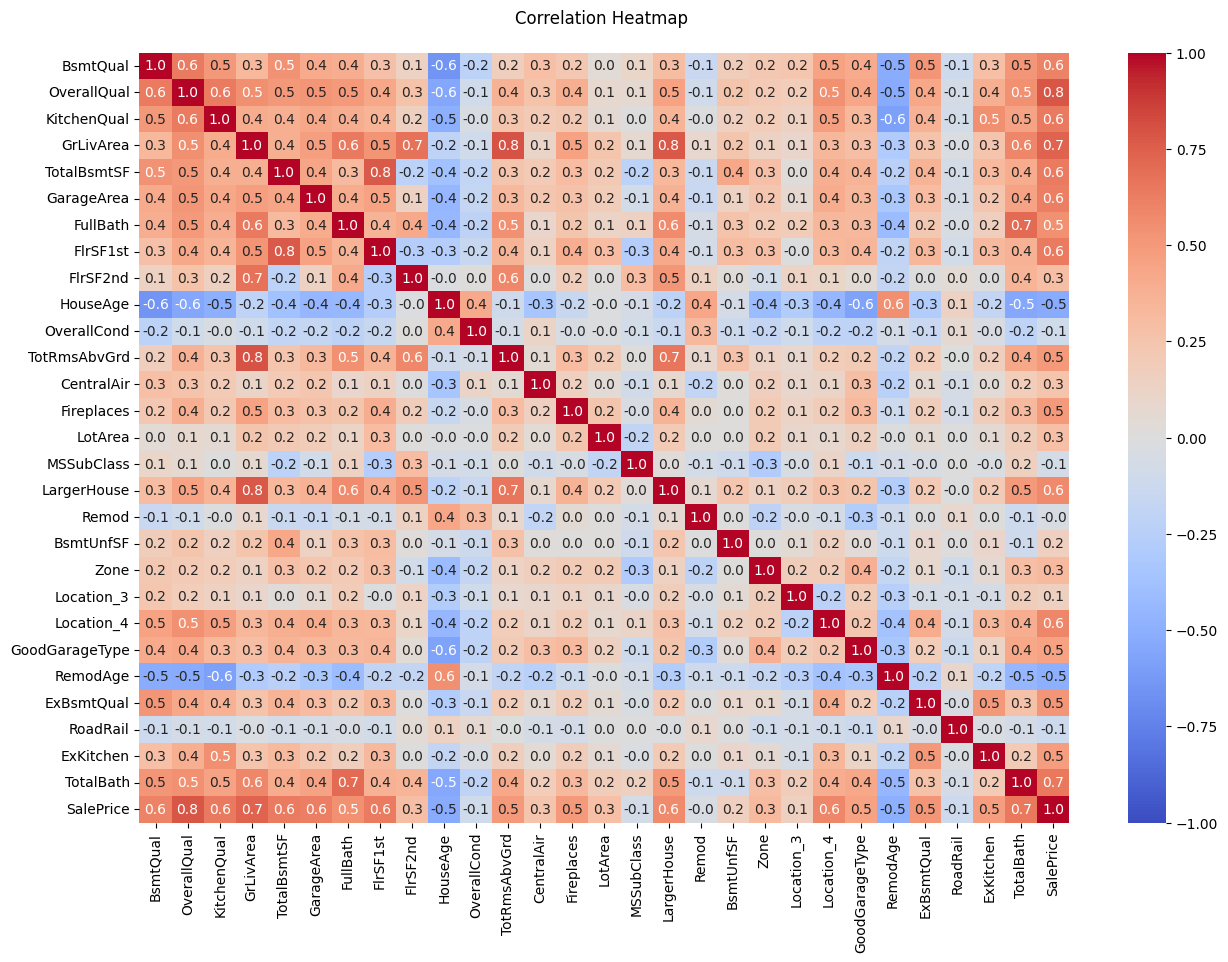

In [3]:
feature_selection = ['BsmtQual' , 'OverallQual' , 'KitchenQual' ,
                    'GrLivArea' , 'TotalBsmtSF'  , 'GarageArea' , 'FullBath' , 'FlrSF1st' , 'FlrSF2nd',
                    'HouseAge'  , 'OverallCond' , 'TotRmsAbvGrd' , 'CentralAir',
                    'Fireplaces' , 'LotArea' , 'MSSubClass' , 'LargerHouse' , 'Remod',
                    'BsmtUnfSF' , 'Zone' , 'Location_3' , 'Location_4' , 'GoodGarageType',
                    'RemodAge' , 'ExBsmtQual' , 'RoadRail' , 'ExKitchen' , 'TotalBath' ]
plt.figure(figsize=(15, 10))

corr_mat = data[feature_selection + ['SalePrice']].corr()

sns.heatmap(corr_mat,
            annot=True,
            fmt='.1f',
            vmin=-1,
            vmax=1,
            cmap='coolwarm'
            )
title = plt.title('Correlation Heatmap \n')

In [4]:
skewness = data[feature_selection].skew().sort_values(ascending=False)
print(skewness[abs(skewness) > 0.75])
skewed_cols = list(skewness[abs(skewness) > 0.75].index)

data['LotArea'] = np.log(data['LotArea'])
data['LotFrontage'] = np.log(data['LotFrontage'])

LotArea       13.647537
ExKitchen      4.212534
RoadRail       3.690437
ExBsmtQual     3.571738
Location_4     1.821239
Location_3     1.405190
MSSubClass     1.339800
FlrSF1st       1.045575
BsmtUnfSF      0.981279
GrLivArea      0.943880
FlrSF2nd       0.804334
Zone          -1.733407
CentralAir    -3.705920
dtype: float64


In [5]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='SalePrice'), data[['SalePrice']], test_size=0.30, random_state=42)

# Model

### Standardization

In [6]:
scaler = StandardScaler()

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = np.log(y_train.reset_index(drop=True)['SalePrice'])
y_test = np.log(y_test.reset_index(drop=True)['SalePrice'])

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[feature_selection]), columns=X_train[feature_selection].columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[feature_selection]), columns=X_test[feature_selection].columns)

## Linear Regression

In [7]:
ols = LinearRegression()
ols.fit(X_train_scaled, y_train)

kf = KFold(n_splits=5, shuffle=True, random_state=10)
cv_scores_shuffled = cross_val_score(ols, X_train_scaled, y_train, cv=kf)
cv_results_RMSE = np.sqrt(-cross_val_score(ols, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_results_RMSE = np.sqrt(-cross_val_score(ols, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))


print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

print('RMSE Shuffled cross validation score:', np.round(cv_results_RMSE, 4))
print('RMSE Mean shuffled cross validation score:', np.round(cv_results_RMSE.mean(), 4))

Shuffled cross validation score: [0.9276 0.9268 0.9325 0.9324 0.9487]
Mean shuffled cross validation score: 0.9336
RMSE Shuffled cross validation score: [0.0947 0.1001 0.0911 0.0974 0.083 ]
RMSE Mean shuffled cross validation score: 0.0933


In [8]:
test_score = ols.score(X_test_scaled, y_test)

print('Test score:', np.round(test_score, 4))

rms = mean_squared_error(y_test, ols.predict(X_test_scaled), squared=False)
print('RMSE Test score:', np.round(rms, 4))

Test score: 0.9313
RMSE Test score: 0.098


In [9]:
yhat_train = ols.predict(X_train_scaled)
yhat_test = ols.predict(X_test_scaled)

train_mse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_mse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_mse_non_log)
print(test_mse_non_log)

16516.368357360374
16940.034066955865


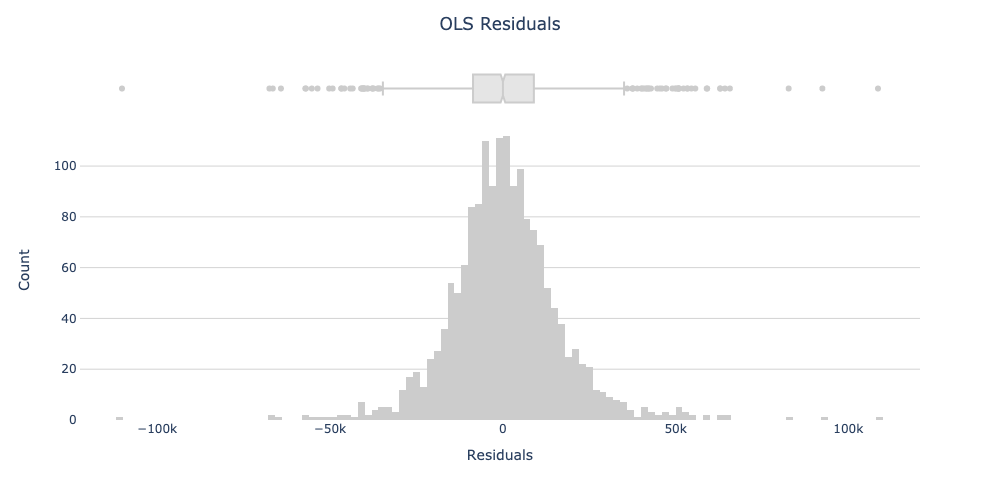

In [10]:
yhat = ols.predict(X_train_scaled)
residuals = y_train - yhat

results = pd.concat([
                pd.concat([X_train, np.exp(y_train)], axis=1), 
                pd.DataFrame(np.exp(yhat), columns=['yhat'])], 
                axis=1
                )

results['residual'] = (results['SalePrice'] - results['yhat'])

#Plot
fig = px.histogram(
                results, 
                x="residual",
                marginal="box",
                width=1000)

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
                title='OLS Residuals', title_x=0.5,
                showlegend=False,
                plot_bgcolor='white')

fig.update_yaxes(
                showline=True,
                gridcolor='lightgray',
                title="Count",
                row=1, col=1)

fig.update_xaxes(
                title="Residuals",
                row=1, col=1)

fig.show()

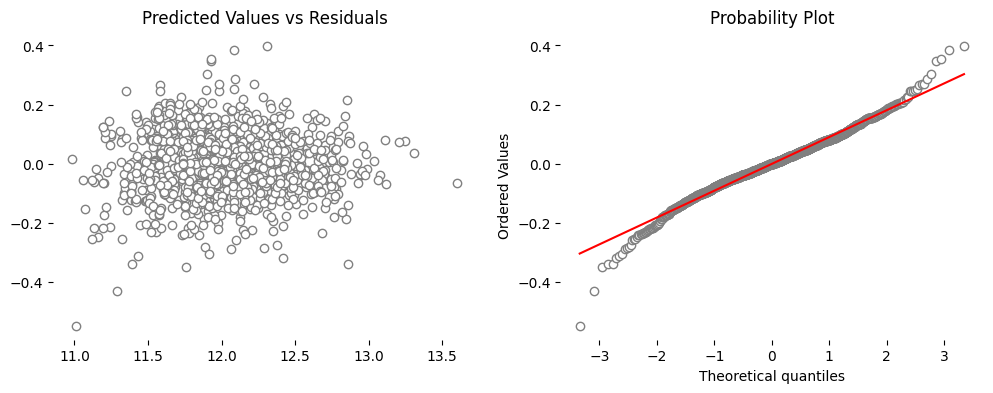

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.despine(left=True, bottom=True)

ax[0].scatter(yhat, residuals, edgecolors='grey', color='white')
ax[0].title.set_text('Predicted Values vs Residuals')

stats.probplot(residuals, dist="norm", plot=plt)
ax[1].get_lines()[0].set_markeredgecolor('grey')
ax[1].get_lines()[0].set_markerfacecolor('white')

plt.show()

In [12]:
res = stats.shapiro(residuals)
res.statistic

0.9815247058868408

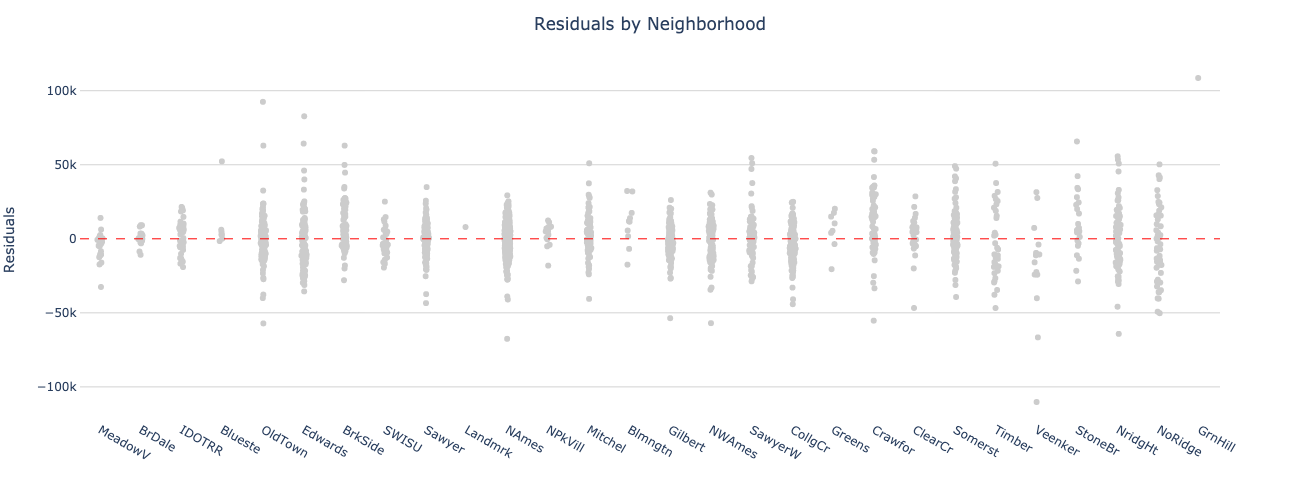

In [13]:
order = results.groupby('Neighborhood').SalePrice.median().sort_values().index

fig = px.strip(
            results, 
            x='Neighborhood', 
            y='residual',
            category_orders={'Neighborhood':order},
            width=1300)  

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
            title='Residuals by Neighborhood', title_x=0.5,
            showlegend=False,
            plot_bgcolor='white')

fig.update_yaxes(
            showline=True,
            gridcolor='lightgray',
            title="Residuals")
            
fig.update_xaxes(
            title=None)

fig.add_hline(y=0, line_width=1, line_dash="dash", line_color="red")

fig.show()

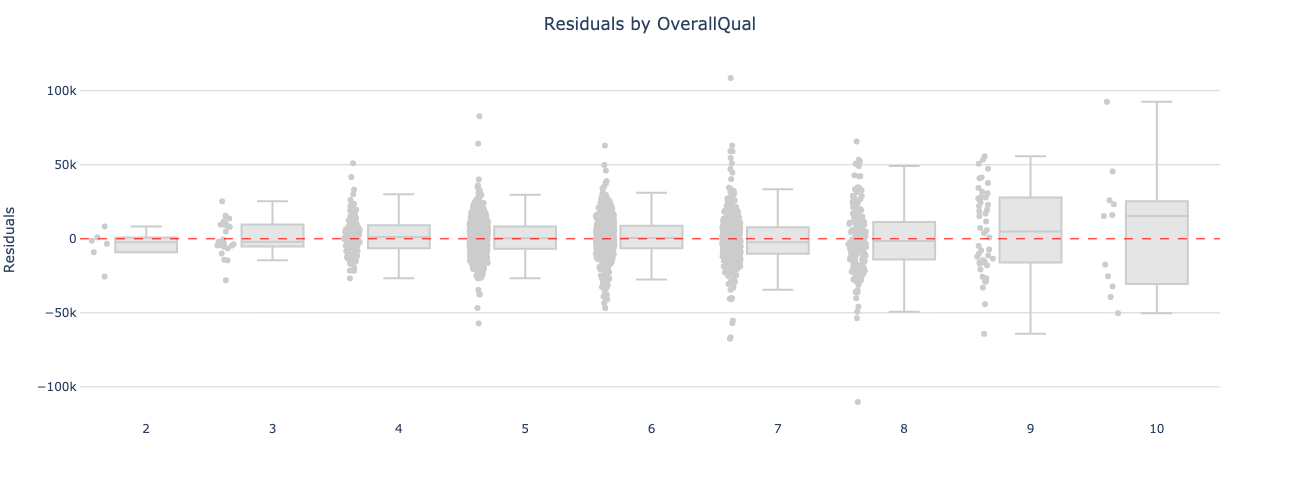

In [14]:
order = results.groupby('OverallQual').SalePrice.median().sort_values().index

fig = px.box(
            results, 
            x='OverallQual', 
            y='residual',
            category_orders={'OverallQual':order},
            points="all",
            width=1300)  

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
            title='Residuals by OverallQual', title_x=0.5,
            showlegend=False,
            plot_bgcolor='white')

fig.update_yaxes(
            showline=True,
            gridcolor='lightgray',
            title="Residuals")
            
fig.update_xaxes(
            title=None)

fig.add_hline(y=0, line_width=1, line_dash="dash", line_color="red")

fig.show()

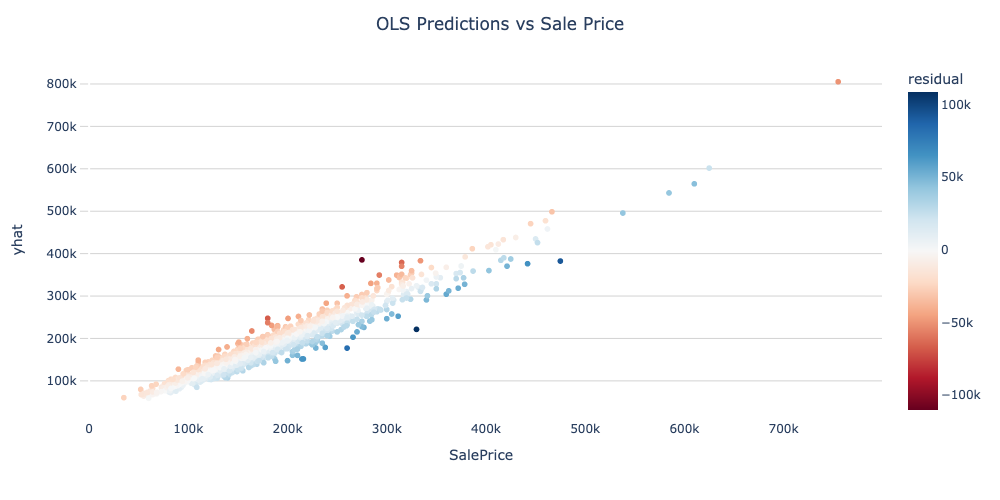

In [15]:
fig = px.scatter(
            results, 
            x='SalePrice', 
            y='yhat',
            color='residual',
            color_continuous_scale='RdBu',
            width=1000)

fig.update_layout(
            title='OLS Predictions vs Sale Price', title_x=0.5,
            showlegend=False,
            plot_bgcolor='white')
            
fig.update_yaxes(
            showline=True,
            gridcolor='lightgray')
            
fig.show()

## Lasso

In [16]:
lasso = LassoCV(cv=5)
lasso.fit(X_train_scaled, y_train)

best_alpha = lasso.alpha_
print('Best alpha:', best_alpha)

# Predict on the test set
y_pred = lasso.predict(X_test_scaled)

# Calculate RMSE
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse_lasso)


Best alpha: 0.0002964851030638202
RMSE: 0.09802871126341456


In [17]:
kf = KFold(n_splits=2, shuffle=True, random_state=10)
cv_scores_shuffled = cross_val_score(lasso, X_train_scaled, y_train, cv=kf)
cv_results_RMSE = np.sqrt(-cross_val_score(lasso, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_results_RMSE = np.sqrt(-cross_val_score(lasso, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))


print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

print('RMSE Shuffled cross validation score:', np.round(cv_results_RMSE, 4))
print('RMSE Mean shuffled cross validation score:', np.round(cv_results_RMSE.mean(), 4))

Shuffled cross validation score: [0.93   0.9378]
Mean shuffled cross validation score: 0.9339
RMSE Shuffled cross validation score: [0.0958 0.0909]
RMSE Mean shuffled cross validation score: 0.0933


In [18]:
yhat_train = lasso.predict(X_train_scaled)
yhat_test = lasso.predict(X_test_scaled)

train_mse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_mse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_mse_non_log)
print(test_mse_non_log)

16495.324991520247
16969.913686485674


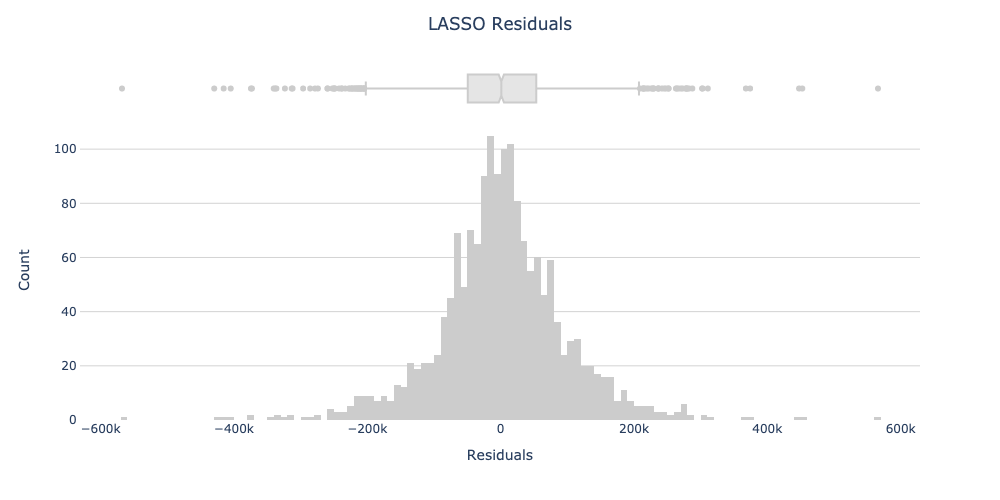

In [19]:
yhat = lasso.predict(X_train_scaled)
residuals = y_train - yhat

results = pd.concat([
                data, 
                pd.DataFrame(np.exp(yhat), columns=['yhat'])], 
                axis=1
                )

results['residual'] = (results['SalePrice'] - results['yhat'])


#Plot
fig = px.histogram(
                results, 
                x="residual",
                marginal="box",
                width=1000)

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
                title='LASSO Residuals', title_x=0.5,
                showlegend=False,
                plot_bgcolor='white')

fig.update_yaxes(
                showline=True,
                gridcolor='lightgray',
                title="Count",
                row=1, col=1)

fig.update_xaxes(
                title="Residuals",
                row=1, col=1)

fig.show()

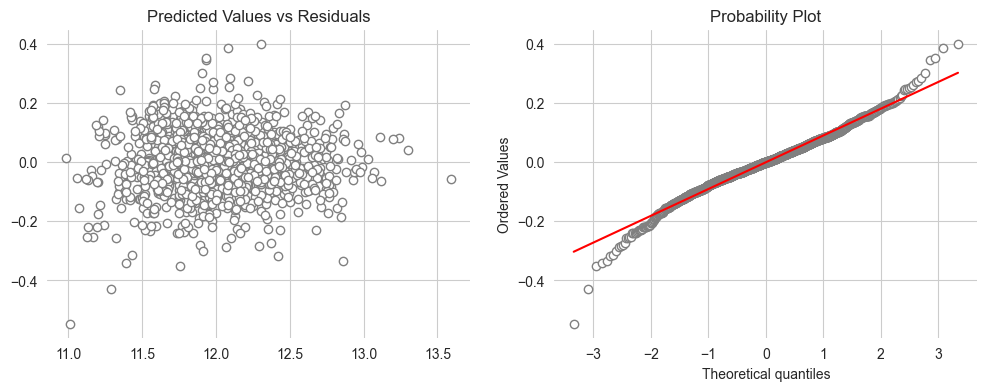

In [20]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.despine(left=True, bottom=True)

ax[0].scatter(yhat, residuals, edgecolors='grey', color='white')
ax[0].title.set_text('Predicted Values vs Residuals')

stats.probplot(residuals, dist="norm", plot=plt)
ax[1].get_lines()[0].set_markeredgecolor('grey')
ax[1].get_lines()[0].set_markerfacecolor('white')

plt.show()

In [21]:
res = stats.shapiro(residuals)
res.statistic

0.9811557531356812

## Ridge

In [22]:
ridge = RidgeCV(cv=5)
ridge.fit(X_train_scaled, y_train)

best_alpha = ridge.alpha_
print('Best alpha:', best_alpha)

# Predict on the test set
y_pred = ridge.predict(X_test_scaled)

# Calculate RMSE
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse_ridge)


Best alpha: 10.0
RMSE: 0.09792863724927406


In [23]:
kf = KFold(n_splits=5, shuffle=True, random_state=10)
cv_scores_shuffled = cross_val_score(ridge, X_train_scaled, y_train, cv=kf)
cv_results_RMSE = np.sqrt(-cross_val_score(ridge, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_results_RMSE = np.sqrt(-cross_val_score(ridge, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))


print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

print('RMSE Shuffled cross validation score:', np.round(cv_results_RMSE, 4))
print('RMSE Mean shuffled cross validation score:', np.round(cv_results_RMSE.mean(), 4))

Shuffled cross validation score: [0.9275 0.9267 0.9329 0.9329 0.9485]
Mean shuffled cross validation score: 0.9337
RMSE Shuffled cross validation score: [0.0948 0.1001 0.0908 0.097  0.0832]
RMSE Mean shuffled cross validation score: 0.0932


In [24]:
yhat_train = ridge.predict(X_train_scaled)
yhat_test = ridge.predict(X_test_scaled)

train_mse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_mse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_mse_non_log)
print(test_mse_non_log)

16511.705241969816
16924.57964319872


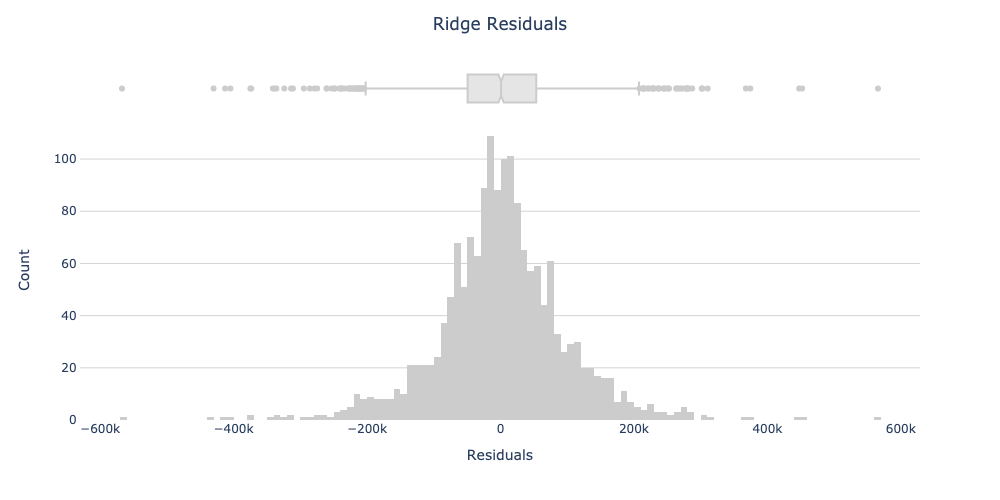

In [25]:
yhat = ridge.predict(X_train_scaled)
residuals = y_train - yhat

results = pd.concat([
                data, 
                pd.DataFrame(np.exp(yhat), columns=['yhat'])], 
                axis=1
                )

results['residual'] = (results['SalePrice'] - results['yhat'])


#Plot
fig = px.histogram(
                results, 
                x="residual",
                marginal="box",
                width=1000)

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
                title='Ridge Residuals', title_x=0.5,
                showlegend=False,
                plot_bgcolor='white')

fig.update_yaxes(
                showline=True,
                gridcolor='lightgray',
                title="Count",
                row=1, col=1)

fig.update_xaxes(
                title="Residuals",
                row=1, col=1)

fig.show()

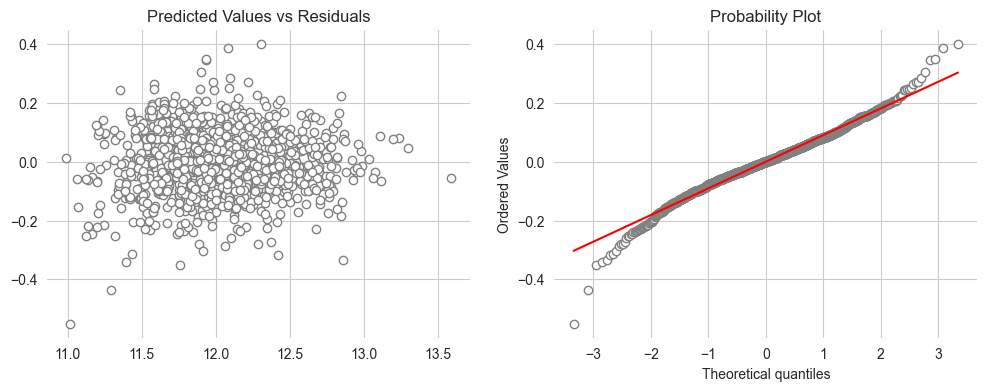

In [26]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.despine(left=True, bottom=True)

ax[0].scatter(yhat, residuals, edgecolors='grey', color='white')
ax[0].title.set_text('Predicted Values vs Residuals')

stats.probplot(residuals, dist="norm", plot=plt)
ax[1].get_lines()[0].set_markeredgecolor('grey')
ax[1].get_lines()[0].set_markerfacecolor('white')

plt.show()

In [27]:
res = stats.shapiro(residuals)
res.statistic

0.9813228845596313

## Stats model

In [28]:
model = sm.OLS.from_formula('SalePrice ~ GrLivArea + Location_4 + GrLivArea:Location_4', data=data).fit()
print(model.params)

Intercept                       48046.380526
Location_4[T.True]             -24105.600305
GrLivArea                          78.012211
GrLivArea:Location_4[T.True]       55.070900
dtype: float64


In [29]:
X_train_scaled_sm = sm.add_constant(X_train_scaled)

model = sm.OLS.from_formula('SalePrice ~  BsmtQual + OverallQual + KitchenQual +\
                    GrLivArea + TotalBsmtSF  + GarageArea + FullBath + FlrSF1st + FlrSF2nd +\
                    HouseAge  + OverallCond + TotRmsAbvGrd + CentralAir +\
                    Fireplaces + LotArea + MSSubClass + LargerHouse + Remod +\
                    BsmtUnfSF + Zone + Location_3 + Location_4 + GoodGarageType+\
                    RemodAge + ExBsmtQual + RoadRail + ExKitchen + TotalBath +\
                    HouseAge:Zone + GarageArea:GoodGarageType + GrLivArea:Fireplaces', 
                    data=pd.concat([X_train_scaled_sm, y_train], axis=1))

results_fu = model.fit()

n = X_train.shape[0]
results_fr = model.fit_regularized(L1_wt=0, alpha=0.9/n, start_params=results_fu.params)

#test_params = np.insert(ridge.coef_, 0, ridge.intercept_, axis=0)
test_params = np.round(results_fr.params, 6)
test_params[0] = results_fu.params[0]

final = sm.regression.linear_model.OLSResults(model, 
                                              test_params,
                                              model.normalized_cov_params)

print(final.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     791.9
Date:                Tue, 18 Jul 2023   Prob (F-statistic):               0.00
Time:                        23:36:35   Log-Likelihood:                 1640.0
No. Observations:                1678   AIC:                            -3216.
Df Residuals:                    1646   BIC:                            -3042.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [30]:
yhat_train = final.predict(X_train_scaled)
yhat_test = final.predict(X_test_scaled)

train_mse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_mse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_mse_non_log)
print(test_mse_non_log)

16391.8763076201
16909.98204461352
